1. Importa as bibliotecas

In [1]:
import tensorflow as tf
import ydf as ydf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

2. Carrega o dataset

In [2]:
train_file_path = "train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


3. Remove a coluna de Id, não necessária para treinamento do modelo

In [3]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


4. Distribuição dos preços das casas

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


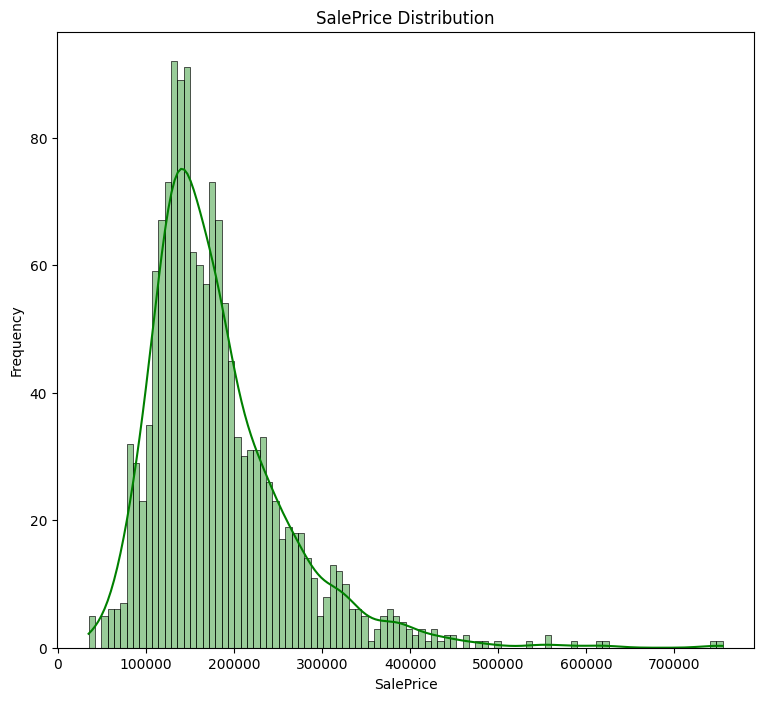

In [4]:
print(dataset_df['SalePrice'].describe())

plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], color='g', bins=100, kde=True, alpha=0.4)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

5. Distribuição numérica dos dados

In [5]:
list(set(dataset_df.dtypes.tolist()))


[dtype('int64'), dtype('O'), dtype('float64')]

In [6]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


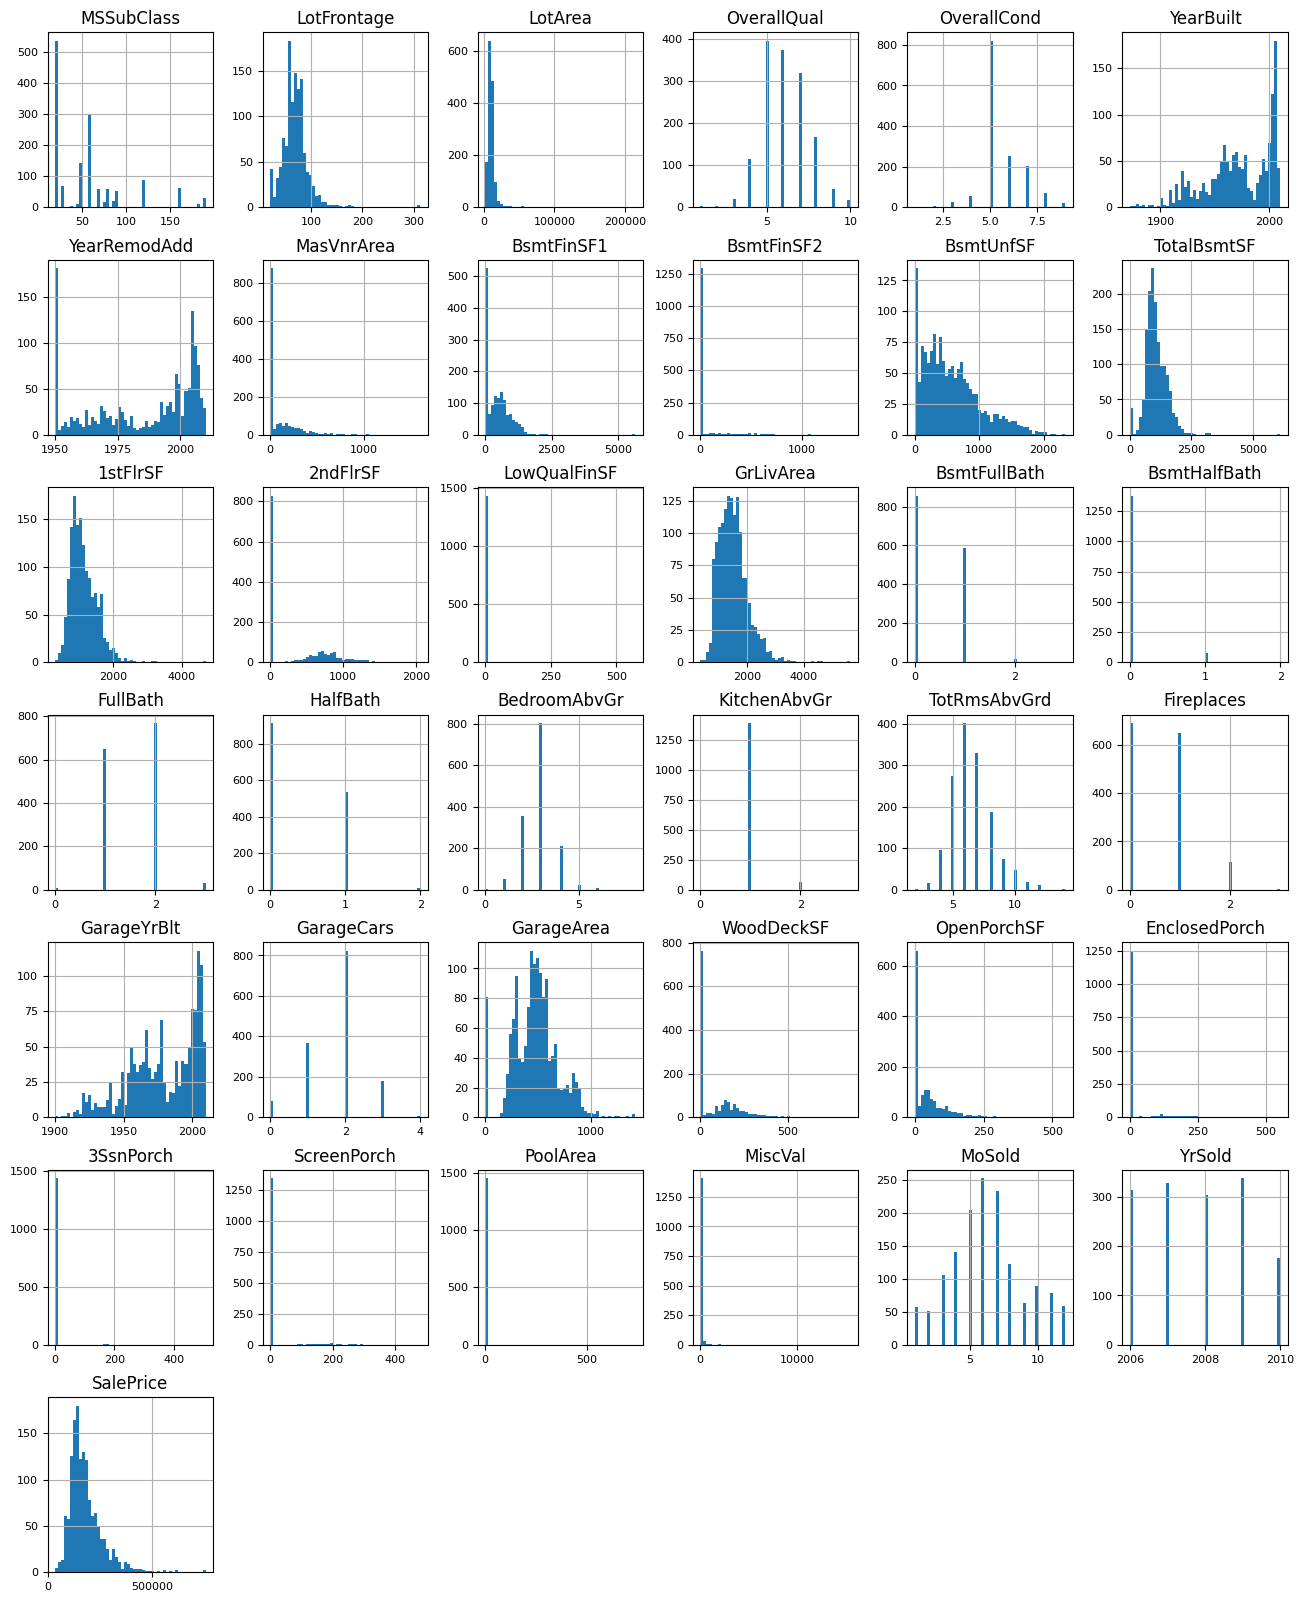

In [7]:
# Plot da distribuição das características numéricas
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

6. Preparo e treino do dataset

In [8]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1039 examples in training, 421 examples in testing.


In [ ]:
label = 'SalePrice'
X_train = train_ds_pd.drop(columns=[label])
y_train = train_ds_pd[label]


X_train_encoded = pd.get_dummies(X_train)

X_valid = valid_ds_pd.drop(columns=[label])
y_valid = valid_ds_pd[label]
X_valid_encoded = pd.get_dummies(X_valid)

X_valid_encoded = X_valid_encoded.reindex(columns = X_train_encoded.columns, fill_value=0)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_encoded, y_train)

y_pred = rf.predict(X_valid_encoded)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

label = 'SalePrice'
X_train = train_ds_pd.drop(columns=[label])
y_train = train_ds_pd[label]

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=300, random_state=42))
])


rf.fit(X_train, y_train)


X_valid = valid_ds_pd.drop(columns=[label])
y_valid = valid_ds_pd[label]


y_pred = rf.predict(X_valid)


7. Avaliação e importância das variáveis

In [ ]:
from sklearn.metrics import mean_squared_error


X_valid = valid_ds_pd.drop(columns=[label])
y_valid = valid_ds_pd[label]

y_pred = rf.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 728268202.16
RMSE: 26986.44


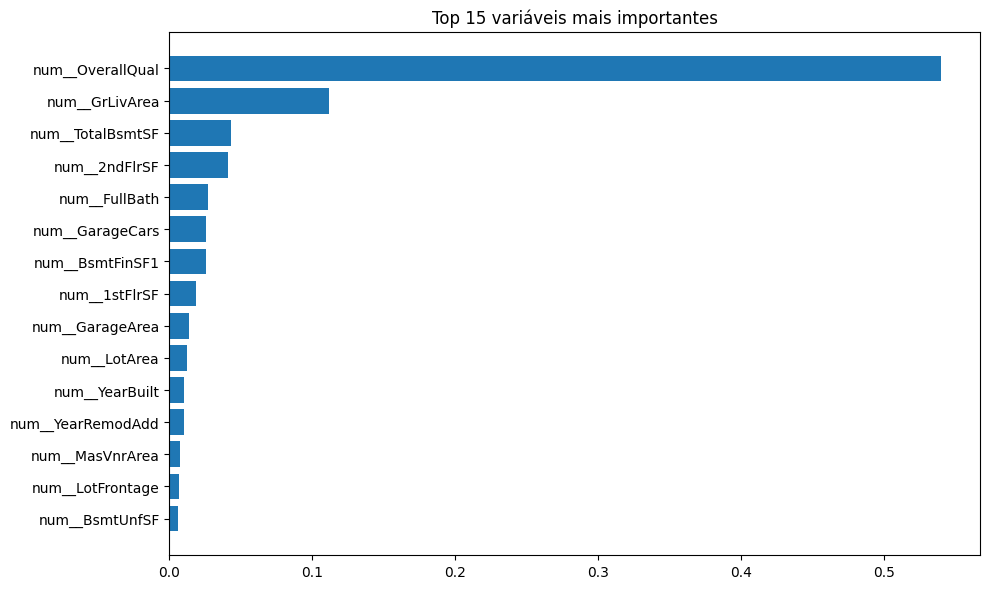

In [ ]:
regressor = rf.named_steps['regressor']

feature_names = rf.named_steps['preprocessor'].get_feature_names_out()

importances = regressor.feature_importances_

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:15], feat_imp['importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 variáveis mais importantes')
plt.tight_layout()
plt.show()

8. Finalização e criação do arquivo de submission

In [ ]:
test_data = pd.read_csv('test.csv')
ids = test_data['Id']

X_test = test_data.drop(columns=['Id'])
y_test_pred = rf.predict(X_test)

submission = pd.DataFrame({'Id': ids, 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)

submission.head()

,Id,SalePrice
0,1461,126689.220000
1,1462,155831.213333
2,1463,185805.313333
3,1464,185904.023333
4,1465,202794.113333
